In [148]:
import numpy as np
import random as random
import matplotlib.pyplot as plt

In [158]:
max = 4.2
step = 0.1
size = round(max / step)
states = np.arange(0, max, step)
actions = np.arange(0, max, step)
T = 2

N = 10000 # number of steps
phi = 15 # soft-min parameter
om_q = 0.85 # rho_q parameter
om_mu = 0.55 # rho_mu parameter
gamma = 0.2 # for production function
rho = 0.95 # discounting (in production function as well)
C = 3 # for production function

jump = round(N / 100) # take a measurement of mu every "jump" step

num_X = len(states)
num_A = len(actions)

Q = np.zeros((T, num_X, num_A), dtype = float) # unified Q function
mu = np.ones([num_X, num_A, T], dtype = float) # separate mean field for each trajectory
mu = mu / 2

supp_W = [0.9, 1.3] # given white noise process with
pmf_W = [0.75, 0.25] # specific supports and probabilities

# calculate expectation of white noise process 
exp_W_gamma = 0
for i in range(len(supp_W)):
    exp_W_gamma += np.pow(supp_W[i], gamma) * pmf_W[i]

# calculate rho * expectation [W ^ gamma]
pEWgamma = rho * exp_W_gamma

max_growth = np.max(supp_W) * C / (pEWgamma) # maximum return on investment (assumes mu = 0
max_wealths = [round(1 / step)]
for t in range(T - 1):
    max_wealths.append(round(max_wealths[t] * max_growth)) # maximum possible wealth at times

for t in range(T):
    for x in range(max_wealths[t] + 1):
        for a in range(x + 1):
            Q[t][x][a] = 30.0 # set Q function to (value) if state-action pair is possible (so soft-max policy explores the unexplored)

# white noise with two outcomes with probabilities established above
def W ():
    return np.random.choice(supp_W, p = pmf_W)

def rhosCalc (count_txa):
    rhoQ = 1 / np.pow(1 + count_txa, om_q)
    rhoMu = 1 / np.pow(1 + count_txa, om_mu)
    return { 'q': rhoQ, 'mu': rhoMu }

# given state/action (by index) and mean field investment
# return through G(mu, W()) * a (amount invested)
# the new state (rounded)
# and using formula for utility calculate reward
def env (state, action, mu):
    consump = states[state] - actions[action]
    production = W() * C / (pEWgamma * (1 + (C - 1) * np.pow(mu, 3)))
    wealth = actions[action] * production
    newState = round(wealth / step)
    utility = np.pow(consump, gamma) / gamma
    # print("%6.4f * %6.4f = %6.4f implies state = %3d" % (actions[action], production, wealth, newState))
    return { 'x': newState, 'u': utility }

# action policy : choose action a given state is x, otherwise use softmin policy
def pi_xa_policy (Q_xa_state, x_idx, a_idx, state):
    if state == x_idx:
        return a_idx
    else:
        return softMinAct(Q_xa_state, state)

# using the formula, calcula te softmax probabilities
# and choose an action given the pmf probabilities
def softMinAct (Q_x, x_idx):
    q = Q_x[:x_idx + 1]
    max_q = np.max(q)

    weights = np.exp(-phi * (max_q - q))
    weights /= weights.sum()
    return np.random.choice(x_idx + 1, p = weights)


In [ ]:
num_Trajs = np.array([int(num_X * (num_A + 1) / 2)])
checkpoint_dist = 1250 # checking viabilities of trajectories happens once every (checkpoint_dist) trials (n)
# frequencyReq = 30.0 # space must have been visited at least once every (frequencyReq) episodes
valueReq = 0.95 # q-value must be at least (valueReq) of the q-value for the optimal action in a state

# beginning of attempt to remove trajectories that are not needed in order to improve efficiency
def checkPathsViability (trajs, traj_totals, count_q, q_table):
    # totalEpisodes = checkpoint_dist * np.sum(traj_totals)
    # episodeReq = np.sqrt(totalEpisodes) / frequencyReq
    episodeReq = 100
    value_req_by_state = valueReq * np.max(q_table, axis = 2)
    traj_removal_mask = []
    for xa in trajs:
        keep = False
        for t in range(T):
            if xa[0] <= max_wealths[t]:
                if count_q[t][xa[0]][xa[1]] < episodeReq:
                    keep = True
                if q_table[t][xa[0]][xa[1]] > value_req_by_state[t][xa[0]]:
                    keep = True
        traj_removal_mask.append(keep)

    inverse_removals = [not elem for elem in traj_removal_mask]
    print([trajs for trajs, inverse_removals in zip(trajs, inverse_removals) if inverse_removals])
    
    return [trajs for trajs, traj_removal_mask in zip(trajs, traj_removal_mask) if traj_removal_mask]

trajectories = []
for x in range(num_X):
    for a in range(x + 1):
        trajectories.append([x, a])

In [160]:
abridgedmu = []
for x in range(num_X):
    abridgedmu.append([])
    
    for a in range(x + 1):
        abridgedmu[x].append([])

        for t in range(T):
            abridgedmu[x][a].append([])


# for rho calc, the amount of times in the (x, a) trajectory it has visited the (x, a) state action pair
update_count = np.zeros([T, num_X, num_A], dtype = int)

# for rho calc, the amount of times, regardless of trajectory, it has visited a specific state action pair
count = np.zeros([T, num_X, num_A], dtype = int)

# error catching
broke = False

for n in range(N):
    
    # print progress on N trials
    # print(n)

    # state initialization randomly for each trajectory
    state = []
    for xa in trajectories:
        state.append(np.random.choice(list(range(0, round(1 / step) + 1))))

    for t in range(T):
        
        index = -1
        for xa in trajectories:

            x = xa[0]
            a = xa[1]
            index += 1

            # use softmin to choose next action
            # print("%3d %3d %3d %3d   " % (state[x][a], x, a, t), end = '')
            action = pi_xa_policy(Q[t][state[index]], x, a, state[index])

            # update counter for rho calculation
            count[t][state[index]][action] += 1
            rhos = rhosCalc(count[t][x][a]) # use [x][a] because will only update Q if state = x -> action = a

            # input state, action, mu into environment
            # and receive new state and cost
            envir = env(state[index], action, mu[x][a][t])
            if envir['x'] >= num_X or envir['x'] < 0:
                if t < T - 1:
                    print("error: %3d %3d %3d %3d %3d %3d %3d" % (envir['x'], action, state[x][a], x, a, t, n))
                    broke = True
                    break
                            
            # update specific mean field
            mu[x][a][t] += rhos['mu'] * (actions[action] - mu[x][a][t])

            # given state matches the trajectory state, update unified Q matrix
            if state[index] == x:
                update_count[t][x][a] += 1
                if t < T - 1:
                    if envir['x'] > 0:
                        max_next_Q = np.max(Q[t + 1, envir['x'], :envir['x'] + 1])
                    else:
                        max_next_Q = Q[t + 1, 0, 0]
                    td_target = envir['u'] + max_next_Q
                else:
                    # if in the end state, can calculate the utility function directly and add to the q-value
                    td_target = envir['u'] + rho * np.pow(envir['x'] * step, gamma) / gamma

                # Q-learning update
                Q[t, state[index], action] = Q[t, state[index], action] + rhos['q'] * (td_target - Q[t, state[index], action])

            # set state as next state
            state[index] = envir['x']

            if n % jump == 0:
                abridgedmu[x][a][t].append(mu[x][a][t])
                
        if broke:
            break
    
    if (n + 1) % checkpoint_dist == 0:
        trajectories = checkPathsViability(trajectories, num_Trajs, update_count, Q)
        num_Trajs = np.append(num_Trajs, len(trajectories))
        print(n)

    if broke:
        break

if broke == False:
    for x in range(num_X):
        for a in range(x + 1):
            for t in range(T):
                abridgedmu[x][a][t].append(mu[x][a][t])

[[3, 3]]
1249
[[8, 8], [11, 0], [11, 1], [11, 2], [11, 3], [11, 4], [11, 6], [11, 7], [11, 8], [11, 9], [11, 10], [11, 11]]
2499
[[14, 0], [14, 1], [14, 2], [14, 4], [14, 5], [14, 6], [14, 7], [14, 8], [14, 10], [14, 11], [14, 12], [14, 13], [14, 14], [17, 14]]
3749
[[12, 1], [12, 2], [12, 3], [12, 4], [12, 5], [12, 7], [12, 8], [12, 9], [12, 12], [16, 2], [16, 5], [16, 6], [16, 7], [16, 13], [16, 14], [16, 15], [17, 2], [17, 3], [17, 9], [17, 11], [17, 13], [17, 15], [17, 17]]
4999
[[12, 0], [12, 6], [12, 11], [16, 0], [16, 1], [16, 4], [16, 8], [16, 9], [16, 11], [16, 12], [17, 0], [17, 1], [17, 5], [17, 6], [17, 7], [17, 8], [17, 10], [17, 16], [20, 0], [20, 2], [20, 5], [20, 6], [20, 7], [20, 10], [20, 12], [20, 14], [20, 20]]
6249
[[16, 3], [16, 16], [17, 4], [20, 1], [20, 3], [20, 8], [20, 9], [20, 11], [20, 13], [20, 15], [20, 16], [20, 17], [20, 18], [20, 19]]
7499
[]
8749
[[6, 6]]
9999


In [161]:
print(num_Trajs)

[903 902 890 876 853 826 812 812 811]


In [162]:
prev_x = 0
prev_a = -1
for xa in trajectories:
    if prev_x < xa[0]:
        for a in range(prev_x - prev_a):
            print("     |", end = '')
        print("")
        for a in range(xa[1]):
            print("     |", end = '')
    else:
        for a in range(xa[1] - prev_a - 1):
            print("     |", end = '')
    print("%2d,%2d|" % (xa[0], xa[1]), end = '')
    prev_x = xa[0]
    prev_a = xa[1]

 0, 0|
 1, 0| 1, 1|
 2, 0| 2, 1| 2, 2|
 3, 0| 3, 1| 3, 2|     |
 4, 0| 4, 1| 4, 2| 4, 3| 4, 4|
 5, 0| 5, 1| 5, 2| 5, 3| 5, 4| 5, 5|
 6, 0| 6, 1| 6, 2| 6, 3| 6, 4| 6, 5|     |
 7, 0| 7, 1| 7, 2| 7, 3| 7, 4| 7, 5| 7, 6| 7, 7|
 8, 0| 8, 1| 8, 2| 8, 3| 8, 4| 8, 5| 8, 6| 8, 7|     |
 9, 0| 9, 1| 9, 2| 9, 3| 9, 4| 9, 5| 9, 6| 9, 7| 9, 8| 9, 9|
10, 0|10, 1|10, 2|10, 3|10, 4|10, 5|10, 6|10, 7|10, 8|10, 9|10,10|
     |     |     |     |     |11, 5|     |     |     |     |     |     |
     |     |     |     |     |     |     |     |     |     |12,10|     |     |
13, 0|13, 1|13, 2|13, 3|13, 4|13, 5|13, 6|13, 7|13, 8|13, 9|13,10|13,11|13,12|13,13|
     |     |     |14, 3|     |     |     |     |     |14, 9|     |     |     |     |     |
15, 0|15, 1|15, 2|15, 3|15, 4|15, 5|15, 6|15, 7|15, 8|15, 9|15,10|15,11|15,12|15,13|15,14|15,15|
     |     |     |     |     |     |     |     |     |     |16,10|     |     |     |     |     |     |
     |     |     |     |     |     |     |     |     |     |     

In [163]:
for t in range (T):
    print("             t = %1d" % (t))
    for x in range (num_X):
        print("x = %5.2f: " % (states[x]), end = '')
        for a in range (x + 1):
            if update_count[t][x][a] == 0:
                print("        ", end = '')
            else:
                print("%7d " % (update_count[t][x][a]), end = '')
        print("")
    print("")

             t = 0
x =  0.00:     879 
x =  0.10:     912     930 
x =  0.20:     940     886     914 
x =  0.30:     941     931     954     111 
x =  0.40:     902     877     926     940     853 
x =  0.50:     913     912     936     924     958     906 
x =  0.60:     875     891     938     895     901     816     825 
x =  0.70:     899     934     928     910     909     870     895     927 
x =  0.80:     914     912     890     880     882     870     867     904     241 
x =  0.90:     898     903     903     948     877     894     863     909     935     881 
x =  1.00:     898     899     907     912     927     934     932     914     936     938     904 
x =  1.10:                                                                                                 
x =  1.20:                                                                                                         
x =  1.30:                                                                                       

In [ ]:
%matplotlib inline
'''
fig, axs = plt.subplots(len(states), len(actions), figsize=(12, 10))

for x in range(num_X):
    for a in range(x + 1):
        axs[x, a].plot(range(0, N + jump, jump), abridgedmu[x][a], color='blue', linewidth = 1)
        axs[x, a].set_title("Mean Field for Trajectory (x = %1d, a = %1d)" % (x, a))'''

'\nfig, axs = plt.subplots(len(states), len(actions), figsize=(12, 10))\n\nfor x in range(num_X):\n    for a in range(x + 1):\n        axs[x, a].plot(range(0, N + jump, jump), abridgedmu[x][a], color=\'blue\', linewidth = 1)\n        axs[x, a].set_title("Mean Field for Trajectory (x = %1d, a = %1d)" % (x, a))'

In [165]:
print("            a = 0  a = 1")
for x in range(num_X):
    print("x = %5.2f:  " % (states[x]), end = '')
    for a in range(x + 1):
        if update_count[0][x][a] > 30:
            print("%5.2f  " % (Q[0][x][a]), end = '')
        else:
            print("       ", end = '')
    print()

            a = 0  a = 1
x =  0.00:  29.96  
x =  0.10:  30.12  29.93  
x =  0.20:  32.07  32.02  29.10  
x =  0.30:  32.10  32.10  32.02  29.60  
x =  0.40:  30.44  30.46  30.45  30.43  29.35  
x =  0.50:  30.64  30.66  30.65  30.65  30.63  29.45  
x =  0.60:  30.90  30.92  30.90  30.89  30.89  30.87  29.67  
x =  0.70:  32.81  32.84  32.83  32.81  32.80  32.77  32.74  29.76  
x =  0.80:  32.82  32.86  32.84  32.83  32.83  32.82  32.82  32.75  29.91  
x =  0.90:  32.83  32.89  32.86  32.87  32.85  32.85  32.85  32.83  32.78  29.69  
x =  1.00:  31.41  31.43  31.43  31.42  31.45  31.43  31.44  31.41  31.43  31.39  29.96  
x =  1.10:                                                                                      
x =  1.20:                                                                                             
x =  1.30:                                                                                                    
x =  1.40:                                                

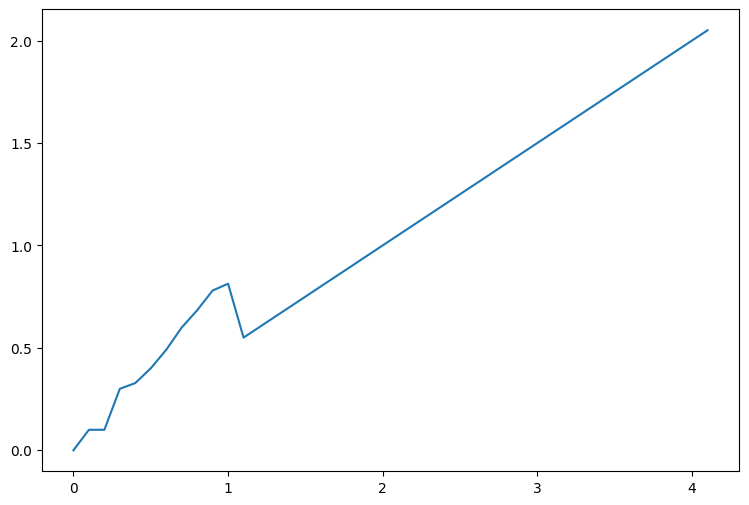

In [ ]:
# utilizing the soft max distribution
# calculate the expectation of an action choice
def softMaxMean (Q_tx, x_idx):
    sum = 0
    expectation = 0
    weights = np.zeros(x_idx + 1)
    for a in range(x_idx + 1):
        weights[a] = np.exp(phi * Q_tx[a])
        sum += weights[a]
        expectation += weights[a] * actions[a]
    return expectation / sum

# iterate through each time step and state to calculate optimal policy from soft max expectation
# only calculate for policy for time/state pairs that were visited at least "qualify" times
qualify = 20
optimIND = []
optim = []
for t in range (T):
    optim.append([])
    optimIND.append([])
    for x in range (size):
        if (np.sum(update_count[t, x]) > qualify):
            optim[t].append(softMaxMean(Q[t, x, :], x))
            optimIND[t].append(states[x])

%matplotlib inline

plt.figure(figsize = (9, 6))
plt.plot(optimIND[0], optim[0])

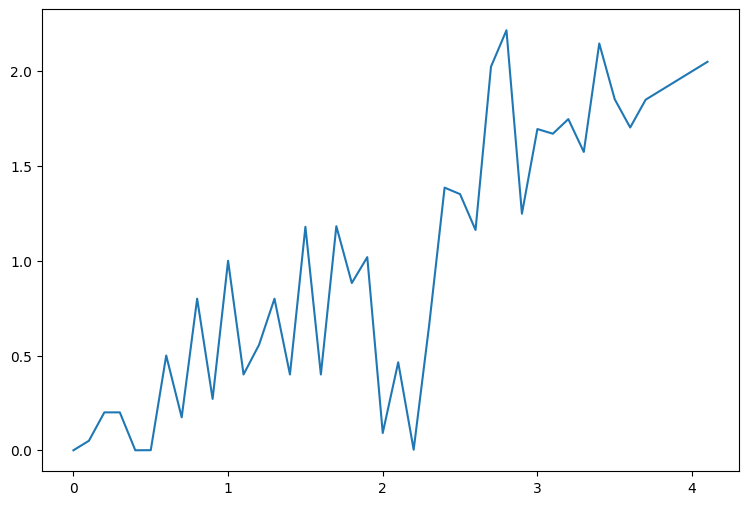

In [ ]:
plt.figure(figsize = (9, 6))
plt.plot(optimIND[1], optim[1])